# FGOALS Forecast

- Loads in all daily forecasts of sea ice
- Regrids to polar stereographic,
- Saves to netcdf files grouped by month of initial date

In [7]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

# Standard Imports
#%matplotlib inline
#%load_ext autoreload
#%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import xesmf as xe
import os
from os import walk
import glob
import seaborn as sns
import pandas as pd
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ESIO Imports
from esio import import_data

import dask
from dask.distributed import Client

In [8]:
client = Client(n_workers=8)
client

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:36989 Dashboard: http://127.0.0.1:36353/status,Cluster Workers: 8 Cores: 16 Memory: 67.47 GB


In [9]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [10]:
# Directories
model='fgoalssipn'
runType='forecast'
base_dir = r'/home/disk/sipn/nicway/data/'
ftp_dir = r'/home/disk/sipn/upload/'
data_dir = os.path.join(base_dir, 'model', model, runType)
data_out = os.path.join(base_dir, 'model', model, runType, 'sipn_nc')
stero_grid_file = os.path.join(base_dir, 'grids', 'stereo_gridinfo.nc')

In [11]:
updateall = False

In [12]:
# look for new data each day and concat into a manageable file

native_dir=os.path.join(data_dir,'native')
orig_dir=os.path.join(native_dir,'orig')
print(orig_dir)

init_dates = []
for (dirpath, dirnames, filenames) in walk(orig_dir):
    init_dates.extend(dirnames)
    break
    
print(init_dates)

for itstr in init_dates:
    itdata_dir=os.path.join(orig_dir,itstr)
    f_out = os.path.join(native_dir,model+'-'+itstr+'.nc')
    if (os.path.isfile(f_out)):
        print(f_out, ' already exists - skipping')
        continue

    ens_dirs = []
    for (dirpath, dirnames, filenames) in walk(itdata_dir):
        ens_dirs.extend(dirnames)
        break
    nens=len(ens_dirs)
    print(nens)
    print(ens_dirs)
    tmp = ens_dirs[0].split('-')
    tmp = tmp[2]
    e=int(tmp[-2:])
    print(e)
    ds_list = []
    for esub in ens_dirs:
        tmp = esub.split('-')
        tmp = tmp[2]
        e=int(tmp[-2:])
        cfiles = os.path.join(itdata_dir, esub, '*.cice.h1.*.nc')  
        print(cfiles)
        ds = xr.open_mfdataset(cfiles, concat_dim='time', chunks={'time': 1, 'nj': 112, 'ni': 320} , parallel=True)

    #    # Add ensemble coord
        ds.coords['ensemble'] = e
        da=ds.aice_d
        da=da.expand_dims('ensemble')
        #print(da)
        ds_list.append(da)

    #print(ds_list)    

    print('merge to one and save file ',f_out)
    ds_all = xr.merge(ds_list)
    print(ds_all)
    ds_all.to_netcdf(f_out)

/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/orig
['20190701', '20190702', '20190703', '20190704', '20190709', '20190601']
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/fgoalssipn-20190701.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/fgoalssipn-20190702.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/fgoalssipn-20190703.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/fgoalssipn-20190704.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/fgoalssipn-20190709.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/fgoalssipn-20190601.nc  already exists - skipping


In [13]:
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [14]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

In [15]:
weights_flag = False # Flag to set up weights have been created
have_grid_file  = False

In [16]:
# CICE model variable names
varnames = ['aice_d']

cd = datetime.datetime.now()
thisyear = cd.year
thismonth = cd.month
print(thisyear,thismonth)

2019 7


In [22]:
# Always import the most recent two months of files (because they get updated)    
for im in [thismonth-1,thismonth]:
#for im in [thismonth-1]:
    cm=im    
    if im==0:
        cm=12
        year=thisyear-1
    else:
        cm = im
        year = thisyear

    # Check any files for this year exist:
    cfiles=glob.glob(os.path.join(data_dir, 'native','*'+str(year)+format(cm, '02')+'*.nc'))
    cfiles = sorted(cfiles) 
    if (len(cfiles)==0):
        print("Skipping since no files found for year and month", year, cm, ".")
        continue    

    print("Procesing year ", year, cm)

    for ifile in cfiles:
        print('   file: ',ifile)
        tmp = ifile.split('-')
        tmp = tmp[1].split('.')
        date=tmp[0]
        itime = np.datetime64(datetime.datetime(int(date[0:4]), int(date[5:6]), int(date[7:8])))
        # print(np.datetime64(date)) # this might have worked
        ds = xr.open_mfdataset(ifile,  parallel=True)
        da = ds.aice_d
        da.coords['init_time'] = itime
        da = da.expand_dims('init_time')
        da = da.rename({'time':'fore_time'})
        #dt_mod = da.time.values[1] - da.time.values[0]
        da.coords['fore_time'] = pd.to_timedelta(np.arange(1,len(da.fore_time)+1,1), unit='D')

        da.name = 'sic'
        da.coords['lon'] = da.TLON
        da.coords['lat'] = da.TLAT
        da = da.drop(['TLAT','TLON'])
        da = da/100 # percent to fraction
        print(da)

        # Calculate regridding matrix
        regridder = xe.Regridder(da, obs_grid, method, periodic=False, reuse_weights=weights_flag)
        weights_flag = True # Set true for following loops

        # Add NaNs to empty rows of matrix (forces any target cell with ANY source cells containing NaN to be NaN)
        if method=='conservative':
            regridder = import_data.add_matrix_NaNs(regridder)

        da_out = regridder(da)
        f_out = os.path.join(data_out, model+'_'+date+'_Stereo.nc')

        print('Saved file', f_out)
        # Save regridded to netcdf file
        da_out.to_netcdf(f_out)

    # Save regridded to multiple netcdf files by month
#         months, datasets = zip(*ds_out_all.groupby('init_time.month'))
#         paths = [os.path.join(data_out, 'GFDL_FLOR_'+str(year)+'_'+str(m)+'_Stereo.nc') for m in months]
#         xr.save_mfdataset(datasets, paths)

da = None # Memory clean up
    

Procesing year  2019 6
   file:  /home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/fgoalssipn-20190601.nc
<xarray.DataArray 'sic' (init_time: 1, ensemble: 40, fore_time: 183, nj: 112, ni: 320)>
dask.array<shape=(1, 40, 183, 112, 320), dtype=float32, chunksize=(1, 40, 183, 112, 320)>
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
  * fore_time  (fore_time) timedelta64[ns] 1 days 2 days ... 182 days 183 days
  * init_time  (init_time) datetime64[ns] 2019-06-01
    lon        (nj, ni) float32 dask.array<shape=(112, 320), chunksize=(112, 320)>
    lat        (nj, ni) float32 dask.array<shape=(112, 320), chunksize=(112, 320)>
Dimensions without coordinates: nj, ni
Reuse existing file: nearest_s2d_112x320_304x448.nc


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xesmf/backend.py:52: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn("Latitude is outside of [-90, 90]")


Saved file /home/disk/sipn/nicway/data/model/fgoalssipn/forecast/sipn_nc/fgoalssipn_20190601_Stereo.nc


In [23]:
# Clean up
if weights_flag:
    regridder.clean_weight_file()  # clean-up

Remove file nearest_s2d_112x320_304x448.nc


In [24]:
client.close()

# Plotting

In [82]:
#ds_new = xr.open_dataset(f_out)

In [83]:
#ds_new

<xarray.Dataset>
Dimensions:    (ensemble: 16, fore_time: 65, init_time: 4, ni: 448, nj: 304)
Coordinates:
    lon        (nj, ni) float64 ...
    lat        (nj, ni) float64 ...
  * init_time  (init_time) datetime64[ns] 2019-07-01 2019-07-02 ... 2019-07-04
  * ensemble   (ensemble) int64 11 12 13 14 21 22 23 24 31 32 33 34 41 42 43 44
  * fore_time  (fore_time) timedelta64[ns] 1 days 2 days ... 64 days 65 days
Dimensions without coordinates: ni, nj
Data variables:
    sic        (init_time, ensemble, fore_time, nj, ni) float64 ...

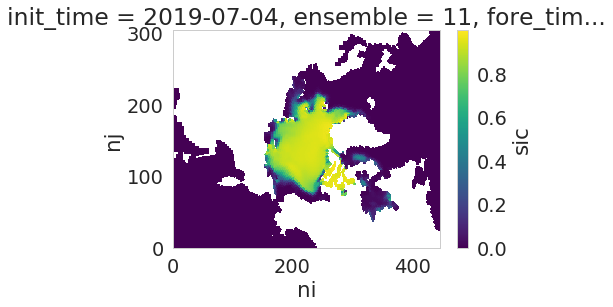

In [90]:
#plt.figure()
#ds_new.sic.sel(ensemble=11).isel(fore_time=0,init_time=3).plot()